In [ ]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed
import lightning as L
import torch
#torch.set_float32_matmul_precision('medium')


with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
train_path="./train"
val_path="./valid"

num_jobs=16

print(train_path)

def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

train_images=get_files(train_path+"/images", ".jpg")
valid_images=get_files(val_path+"/images", ".jpg")
train_labels=get_files(train_path+"/labels", ".txt")
valid_labels=get_files(val_path+"/labels", ".txt")

In [2]:
def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(train_path+"/labels/"+file) for file in train_labels)
df=pd.concat(df_collection, ignore_index=True)

In [3]:
df_valid=pd.concat(Parallel(n_jobs=16)(delayed(read_and_process_file)(val_path+"/labels/"+file) for file in valid_labels), ignore_index=True)

In [4]:
# show rows with image 998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg
df[df['image']=='998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg']

,class,x,y,w,h,image
52923,34,0.360577,0.737981,0.097356,0.045673,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52924,8,0.370192,0.640625,0.100962,0.048077,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52925,11,0.399038,0.538462,0.100962,0.062500,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52926,11,0.808894,0.402644,0.100962,0.063702,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...


In [5]:
# get maximum number of bounding boxes in an image
max_boxes=df['image'].value_counts().max()
max_boxes

4

In [6]:
train_path=train_path+"/images"
val_path=val_path+"/images"

In [7]:
df['class'].unique().min()

0

In [8]:
# increase all classes by 1
df['class'] = df['class']+1
df['class'].unique().min()

1

In [9]:
class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)

In [10]:
import imageio.v2 as imageio
train_chunks = [group for _, group in df.groupby('image')]
valid_chunks = [group for _, group in df_valid.groupby('image')]
def read_image_and_bbox(chunck, train_path):
    image = imageio.imread(train_path+"/"+chunck.iloc[0]['image'])
    image = Image.fromarray(image)
    return {"image": image, "chunck": chunck}

train_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, train_path) for chunck in train_chunks)
valid_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, val_path) for chunck in valid_chunks)

In [11]:
len(train_data), len(valid_data)

(14000, 4000)

In [12]:
train_data[0]["chunck"]

,class,x,y,w,h,image
0,52,0.460337,0.693510,0.064904,0.042067,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...
1,38,0.644231,0.501202,0.063702,0.088942,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...
2,38,0.614183,0.074519,0.064904,0.088942,000090528_jpg.rf.d50e89610e5c97c61632c290692f3...


<Axes: >

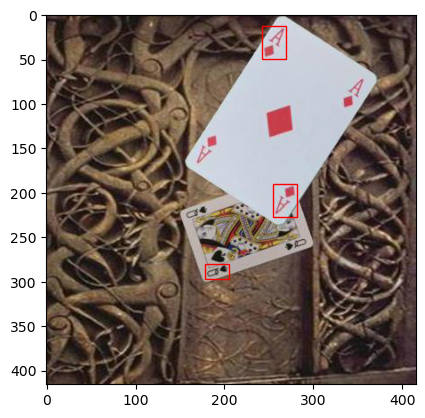

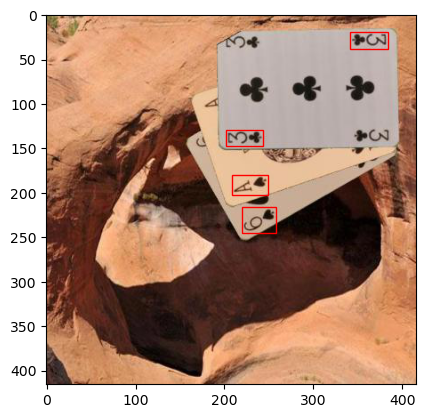

In [13]:
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

show_boxes(train_data[0])
show_boxes(train_data[1230])

In [14]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.df = df
        self.data = data
        self.size=len(data)
        self.transform = transform
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        boxes=self.data[idx]["chunck"][['x', 'y', 'w', 'h']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {}
        target['boxes'] = boxes
        if len(target['boxes'])<4:
            target['boxes']=torch.cat((target['boxes'], torch.zeros(4-len(target['boxes']), 4)))
        #transform
        if self.transform:
            image = self.transform(image)
        #print("image.shape in dataset", image.shape)
        #print("target in dataset", target)
        return image, target, idx
    
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])
dataset = Dataset(train_data, transform)
image, target, _ = dataset[0]

print(image.shape)

print(target)

torch.Size([3, 416, 416])
{'boxes': tensor([[0.4603, 0.6935, 0.0649, 0.0421],
        [0.6442, 0.5012, 0.0637, 0.0889],
        [0.6142, 0.0745, 0.0649, 0.0889],
        [0.0000, 0.0000, 0.0000, 0.0000]])}


In [15]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn.functional as F


objectness_loss_fn=torch.nn.BCELoss()
mse=torch.nn.MSELoss()

def loss_fun(output, target):
    number_boxes=4
    neurons_per_box=4
    output=output.view(-1, number_boxes, neurons_per_box)
    mse_loss=mse(output*100, target*100)   
    return mse_loss
    

In [16]:
def generate_sample_output(loader, model):
    cols=['x', 'y', 'w', 'h']
    output_data=[]
    for xb, yb, idx in loader:
        xb=xb.to(device)
        yb['boxes']=yb['boxes'].to(device)
        
        output=model(xb)
        for i in range(output.shape[0]):
            # create image from xb tensor
            image=xb[i].detach().cpu().numpy().transpose(1,2,0)
            # convert to PIL
            image=Image.fromarray((image*255).astype(np.uint8))
            df_chunk=pd.DataFrame(columns=cols)
            for j in range(4):            
                x,y,w,h=output[i, j*4:(j+1)*4].detach().cpu().numpy()
                df_chunk.loc[j]=[x,y,w,h]
            output_data.append({
                    'image': image,
                    'chunck': df_chunk
                })
        break

    fig, ax=plt.subplots(5, 5, figsize=(20, 20))
    for row in range(5):
        for col in range(5):
            show_boxes(output_data[row*5+col], show_class=False, ax=ax[row, col])
    return fig
        

In [17]:
class MyLightningDataModule(L.LightningDataModule):
    def __init__(self, train_data, valid_data, transform, batch_size=32, num_workers=0):
        super().__init__()
        self.train_data=train_data
        self.valid_data=valid_data
        self.transform=transform
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.train_dataset=Dataset(train_data, transform)
        self.valid_dataset=Dataset(valid_data, transform)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [18]:
import torchvision
from torchvision.models import ResNet50_Weights
import torch


class Model(L.LightningModule):
    def __init__(self, loss_fun=None, hidden_size=None, dropout=0.4, params=None, train_dataset=None, val_dataset=None):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_output_size=1000
        number_boxes=4
        self.neurons_per_box=4      
        output_neurons=number_boxes*self.neurons_per_box
        self.loss_fun=loss_fun
        self.params=params
        self.train_dataset=train_dataset
        self.val_dataset=val_dataset
        
        self.head=torch.nn.Sequential(
            torch.nn.Linear(self.backbone_output_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, output_neurons),
            torch.nn.Sigmoid()
        )
              
        # freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.freezed_backbone=True
        
            
    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.freezed_backbone=False
 
    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.head(x)
        return x
    
    def custom_log(self, name, value):
        self.log(name, value, prog_bar=True, logger=True)
        self.logger.run[name]=value
    
    def training_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("train_loss", loss.detach())
        self.custom_log("lr", self.trainer.optimizers[0].param_groups[0]['lr'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("val_loss", loss.detach())
        return loss
    
    def on_train_epoch_end(self) -> None:
        epoch=self.current_epoch
        if epoch==self.params['unfreeze_epoch']:
            self.unfreeze_backbone()
        image=generate_sample_output(self.train_dataloader(), self)
        self.logger.run["sample images epoch "+str(epoch)].upload(image)
        return super().on_train_epoch_end()
    
    def configure_optimizers(self):
        print("self.trainer", self.trainer.datamodule.train_dataloader())
        lr=self.params['lr']
        optimizer=torch.optim.AdamW([
            {'params': model.head.parameters(), 'lr':lr}, 
            {'params': model.backbone.layer4.parameters(), 'lr':lr*self.params['layer4_lr_factor']}, 
            {'params': model.backbone.layer3.parameters(), 'lr':lr*self.params['layer3_lr_factor']}, 
            {'params': model.backbone.layer2.parameters(), 'lr':lr*self.params['layer2_lr_factor']}, 
            {'params': model.backbone.layer1.parameters(), 'lr':lr*self.params['layer1_lr_factor']}],
        weight_decay=self.params['wd'])
        scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.params['lr'], steps_per_epoch=len(self.trainer.datamodule.train_dataloader()), epochs=self.params['epochs'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }
        
        
from lightning.pytorch.callbacks import ModelCheckpoint


model=Model(hidden_size=1000, loss_fun=loss_fun)
loader=torch.utils.data.DataLoader(dataset, batch_size=13, shuffle=True)
for image, target, _ in loader:
    print(image.shape)
    output=model(image)
    assert output.shape[0]==13, "batch size is not correct, its "+str(output.shape[0])
    print(output.shape) 
    break


torch.Size([13, 3, 416, 416])
torch.Size([13, 16])


In [19]:
import neptune



In [20]:
from lightning.pytorch.loggers import NeptuneLogger
import neptune

hidden_size=1000
lr=1e-4
wd=0.0001
bs=56
epochs=40
unfreeze_backbone_n_epoch=5
params = {
    "lr": lr, 
    "optimizer": "AdamW", 
    "wd": wd,
    "batch_size": bs,
    "epochs": epochs,
    "unfreeze_epoch": unfreeze_backbone_n_epoch,
    "hidden_size": hidden_size,
    "layer4_lr_factor": 0.01,
    "layer3_lr_factor": 0.01,
    "layer2_lr_factor": 0.001,
    "layer1_lr_factor": 0.001
}
model=Model(hidden_size=hidden_size, loss_fun=loss_fun, params=params, train_dataset=Dataset(train_data, transform), val_dataset=Dataset(valid_data, transform))

neptune_logger = NeptuneLogger(
    project="bernd.heidemann/cards-detection",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
    log_model_checkpoints=False
)

neptune_logger.log_hyperparams(params=params)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath="models/",
    filename="cards_bbox-{epoch:02d}-{val_loss:.2f}",
)

#run["parameters"] = params

dm=MyLightningDataModule(train_data, valid_data, transform, batch_size=bs, num_workers=0)

trainer=L.Trainer(max_epochs=epochs, logger=neptune_logger, callbacks=[checkpoint_callback])
trainer.fit(model, dm)


c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/bernd.heidemann/cards-detection/e/CAR-131


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\Bernd\_developer\cards_object_detection\models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | ResNet     | 25.6 M
1 | head     | Sequential | 2.0 M 
----------------------------------------
2.0 M     Trainable params
25.6 M    Non-tr

self.trainer <torch.utils.data.dataloader.DataLoader object at 0x000001D835AB30A0>


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MisconfigurationException: `train_dataloader` must be implemented to be used with the Lightning Trainer

Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 249.0


In [ ]:
generate_sample_output(model.val_dataloader(), model)



RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
# save model
torch.save(model.state_dict(), "model_"+run["sys/id"].fetch()+".pth")